# Data Loading

In [1]:
#Install Important Libs
%pip install -q datasets transformers pydantic matplotlib



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Optional, Literal
from pydantic import BaseModel, Field

# Environment Check before running the code

In [3]:
import importlib
from typing import Optional, Literal
from pydantic import BaseModel

# --- Safe optional imports ---
if importlib.util.find_spec("torch"):
    import torch
else:
    torch = None

if importlib.util.find_spec("datasets"):
    import datasets
else:
    datasets = None

if importlib.util.find_spec("transformers"):
    import transformers
else:
    transformers = None


class LibraryVersions(BaseModel):
    torch: str = " Not Installed"
    datasets: str = " Not Installed"
    transformers: str = " Not Installed"


class GPUInfo(BaseModel):
    device: Literal["GPU", "CPU", "No Device Detected"]
    cuda_version: Optional[str] = None
    gpu_name: Optional[str] = None
    memory_gb: Optional[float] = None
    message: Optional[str] = None


class EnvironmentCheck:
    """Environment checker with Pydantic models."""

    def __init__(self) -> None:
        self.torch_version = torch.__version__ if torch else None
        self.datasets_version = datasets.__version__ if datasets else None
        self.transformers_version = transformers.__version__ if transformers else None

    def get_versions(self) -> LibraryVersions:
        """Return installed library versions as a Pydantic model."""
        return LibraryVersions(
            torch=self.torch_version or " Not Installed",
            datasets=self.datasets_version or " Not Installed",
            transformers=self.transformers_version or " Not Installed",
        )

    def check_gpu(self) -> GPUInfo:
        """Return GPU details as a Pydantic model."""
        if not torch:
            return GPUInfo(device="No Device Detected")

        if torch.cuda.is_available():
            props = torch.cuda.get_device_properties(0)
            return GPUInfo(
                device="GPU",
                cuda_version=torch.version.cuda,
                gpu_name=torch.cuda.get_device_name(0),
                memory_gb=round(props.total_memory / (1024**3), 2),
            )
        return GPUInfo(device="CPU", message="No GPU detected")


# --- Usage for manual run ---
if __name__ == "__main__":
    env = EnvironmentCheck()
    print("Library Versions:", env.get_versions().model_dump())
    print("Device Info:", env.check_gpu().model_dump())


Library Versions: {'torch': '2.8.0.dev20250319+cu128', 'datasets': '4.0.0', 'transformers': '4.56.0'}
Device Info: {'device': 'GPU', 'cuda_version': '12.8', 'gpu_name': 'NVIDIA L4', 'memory_gb': 21.95, 'message': None}


# Data Loading

In [4]:
from typing import Optional
from pydantic import BaseModel, Field
from datasets import load_dataset, DatasetDict


class DatasetConfig(BaseModel):
    """Configuration model for dataset loading."""
    dataset_name: str = Field(..., description="Name of the dataset to load (e.g., 'wikitext').")
    subset_name: str = Field(..., description="Subset/config name (e.g., 'wikitext-2-raw-v1').")


class DatasetLoader:
    """Wrapper class for loading HuggingFace datasets."""

    def __init__(self, config: DatasetConfig) -> None:
        self.config = config

    def load_data(self) -> DatasetDict:
        """Load dataset using HuggingFace."""
        dataset = load_dataset(self.config.dataset_name, self.config.subset_name)
        return dataset


config = DatasetConfig(dataset_name="wikitext", subset_name="wikitext-2-raw-v1")
loader = DatasetLoader(config)
dataset = loader.load_data()

print(dataset)
for i in range(10):
    print(f"Row {i}: {dataset['train'][i]['text']!r}")



README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})
Row 0: ''
Row 1: ' = Valkyria Chronicles III = \n'
Row 2: ''
Row 3: ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Im

# Environment Setup and Dataset Preparation

🔹 Environment Setup

Before training a language model, we must ensure the environment is ready:

Libraries: PyTorch for neural networks, HuggingFace datasets for loading corpora, and transformers for tokenization.

GPU Availability: Training transformers on CPU is not practical. We verified CUDA version, GPU type, and VRAM size.

Reproducibility: Using a structured check (EnvironmentCheck), we can confirm dependencies and hardware setup are consistent across machines.

🔹 Dataset Preparation in LLM Training

Large-scale models are trained on diverse, massive corpora:

🌍 Common Crawl → large-scale web scrape (cleaned and deduplicated).

📚 Books → public-domain and licensed.

📝 Wikipedia → factual, well-structured text.

💻 Code → GitHub, forums, Q&A.

🧪 Research Articles → scientific sources like arXiv and PubMed.

Such datasets often reach billions to trillions of tokens. Preprocessing includes deduplication, filtering, and quality checks.

🔹 Our Choice for EduMoE

For this educational project, we use:

✅ WikiText-2 (raw):

~2M tokens — small enough for fast experiments.

Natural, factual prose similar to real-world corpora.

Already split into train, validation, and test.

Includes quirks like blank lines, which helps mimic real preprocessing challenges.

This dataset is ideal for learning the mechanics of LLM training without overwhelming compute resources.

# Tokenization

In [5]:
from typing import List
from pydantic import BaseModel, Field
from transformers import AutoTokenizer


class TokenizerConfig(BaseModel):
    """Configuration for tokenizer setup."""
    tokenizer_name: str = Field(default="gpt2", description="Pretrained tokenizer to use.")
    add_special_tokens: bool = Field(default=False, description="Whether to add special tokens like BOS/EOS.")


class TokenizerWrapper:
    """Wrapper for HuggingFace GPT-2 tokenizer."""

    def __init__(self, config: TokenizerConfig) -> None:
        self.config = config
        self.tokenizer = AutoTokenizer.from_pretrained(config.tokenizer_name)

        # GPT-2 has no pad token by default → we assign EOS as pad for batching
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def encode(self, text: str) -> List[int]:
        """Convert text → token IDs."""
        return self.tokenizer.encode(text, add_special_tokens=self.config.add_special_tokens)

    def decode(self, tokens: List[int]) -> str:
        """Convert token IDs → text."""
        return self.tokenizer.decode(tokens)

    def vocab_size(self) -> int:
        """Return vocabulary size."""
        return self.tokenizer.vocab_size
        

# --- Usage ---
if __name__ == "__main__":
    config = TokenizerConfig(tokenizer_name="gpt2", add_special_tokens=False)
    tok = TokenizerWrapper(config)

    text = "EduMoE is our Mixture of Experts project."
    tokens = tok.encode(text)
    decoded = tok.decode(tokens)

    print("Vocab size:", tok.vocab_size())
    print("Text:", text)
    print("Tokens:", tokens)
    print("Decoded:", decoded)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Vocab size: 50257
Text: EduMoE is our Mixture of Experts project.
Tokens: [36, 646, 16632, 36, 318, 674, 337, 9602, 286, 36095, 1628, 13]
Decoded: EduMoE is our Mixture of Experts project.


# Tokenize WikiText-2 with Our Classes

In [6]:
# 1. Load WikiText-2 (raw)
data_config = DatasetConfig(dataset_name="wikitext", subset_name="wikitext-2-raw-v1")
dataset_loader = DatasetLoader(data_config)
dataset = dataset_loader.load_data()

# 2. Load GPT-2 Byte-Level BPE tokenizer
tok_config = TokenizerConfig(tokenizer_name="gpt2", add_special_tokens=False)
tokenizer = TokenizerWrapper(tok_config)

# 3. Grab a non-empty sample from training set
sample_text = next(x["text"] for x in dataset["train"] if x["text"].strip() != "")

# 4. Encode → token IDs
token_ids = tokenizer.encode(sample_text)

# 5. Decode → back to text
decoded_text = tokenizer.decode(token_ids)

# 6. Print results
print("Original text:\n", sample_text[:200], "\n")
print("Token IDs (first 40):\n", token_ids[:40], "...\n")
print("Decoded text:\n", decoded_text[:200], "\n")
print("Char length vs Token length:", len(sample_text), "chars →", len(token_ids), "tokens")
print("Tokenizer vocab size:", tokenizer.vocab_size())


Original text:
  = Valkyria Chronicles III = 
 

Token IDs (first 40):
 [796, 569, 18354, 7496, 17740, 6711, 796, 220, 198] ...

Decoded text:
  = Valkyria Chronicles III = 
 

Char length vs Token length: 30 chars → 9 tokens
Tokenizer vocab size: 50257


# Before implementing MOE , We will be implementing a decoder style transformer and then convert it into a MOE Type design
# This is how a gpt-2 style model looks like
![Capture](images/Capture.PNG)

# Embedding
![emblookup](images/emblookup.PNG)
![learn_para](images/learn_para.PNG)

# We will using nn.embedding as a safe wrapper for lookup table and otherwise
![nn.emb.PNG](images/nn.emb.PNG)

In [7]:
from pydantic import BaseModel, Field
import torch
import torch.nn as nn

class EmbeddingConfig(BaseModel):
    """Configuration for token embeddings."""
    vocab_size: int = Field(..., description="Number of tokens in the vocabulary")
    embedding_dim: int = Field(..., description="Dimension of each embedding vector")

class TokenEmbedding(nn.Module):
    """Embedding layer for tokens."""

    def __init__(self, config: EmbeddingConfig) -> None:
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.embedding_dim
        )

    def forward(self, token_ids: torch.Tensor) -> torch.Tensor:
        """
        Map token IDs to embedding vectors.
        Args:
            token_ids (Tensor): shape (batch_size, seq_len)
        Returns:
            Tensor: shape (batch_size, seq_len, embedding_dim)
        """
        return self.embedding(token_ids)




# Connecting everything till now

In [8]:
# 1. Load WikiText-2 dataset
data_config = DatasetConfig(dataset_name="wikitext", subset_name="wikitext-2-raw-v1")
dataset_loader = DatasetLoader(data_config)
dataset = dataset_loader.load_data()

# 2. Load tokenizer (GPT-2 BBPE)
tok_config = TokenizerConfig(tokenizer_name="gpt2", add_special_tokens=False)
tokenizer = TokenizerWrapper(tok_config)

# 3. Get vocab size from tokenizer
vocab_size = tokenizer.vocab_size()
embedding_dim = 128   # keep small for demo, GPT-2 uses 768

# 4. Create embedding layer
embed_config = EmbeddingConfig(vocab_size=vocab_size, embedding_dim=embedding_dim)
embed_layer = TokenEmbedding(embed_config)

# 5. Take one sample from dataset (non-empty)
sample_text = next(x["text"] for x in dataset["train"] if x["text"].strip() != "")
print("Original text:", sample_text[:100], "\n")

# 6. Tokenize → IDs
token_ids = tokenizer.encode(sample_text)
token_tensor = torch.tensor([token_ids])  # add batch dim

print("Token IDs:", token_ids[:20], "...\n")

# 7. Pass through embeddings
vectors = embed_layer(token_tensor)
print("Embeddings shape:", vectors.shape)
print("First token vector (truncated):", vectors[0, 0, :10])


Original text:  = Valkyria Chronicles III = 
 

Token IDs: [796, 569, 18354, 7496, 17740, 6711, 796, 220, 198] ...

Embeddings shape: torch.Size([1, 9, 128])
First token vector (truncated): tensor([ 0.8287, -2.2590,  1.3271,  1.7072,  1.0055,  1.2934,  0.6259,  0.2036,
        -0.1191, -1.4831], grad_fn=<SliceBackward0>)


# positional embeddings

# Formula
![pos_emb](images/pos_emb.PNG)

# Benifits
![pos_emb_1](images/pos_emb_1.PNG)

# the sinusoidal positional encoding (original Transformer, Vaswani et al. 2017) is not learnable.

# Lately system use somehting known Rotary Position Embeddings (RoPE)

In [9]:
import torch
import torch.nn as nn
import math
from pydantic import BaseModel, Field


class PositionalEncodingConfig(BaseModel):
    """Configuration for sinusoidal positional encoding."""
    embedding_dim: int = Field(..., description="Embedding dimension (same as token embeddings)")
    max_len: int = Field(5000, description="Maximum sequence length (context window)")


class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding (Vaswani et al. 2017)."""

    def __init__(self, config: PositionalEncodingConfig) -> None:
        super().__init__()
        self.config = config
        d_model = config.embedding_dim
        max_len = config.max_len

        # Create matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)

        # Position indices: (max_len, 1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Different frequencies for each dimension (0,2,4,...)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension: (1, max_len, d_model)
        pe = pe.unsqueeze(0)

        # Register as buffer → not learnable, moves with model to GPU
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor (batch_size, seq_len, embedding_dim)
        Returns:
            Tensor with positional encoding added
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


In [10]:
# Token embeddings first
embed_config = EmbeddingConfig(vocab_size=50257, embedding_dim=128)
embed_layer = TokenEmbedding(embed_config)

# Positional encodings
pos_config = PositionalEncodingConfig(embedding_dim=128, max_len=512)
pos_encoder = PositionalEncoding(pos_config)

# Example input: 1 sentence, 9 tokens
token_ids = torch.tensor([[796, 569, 18354, 7496, 17740, 6711, 796, 220, 198]])
token_vectors = embed_layer(token_ids)

print("Before Positional Encoding:", token_vectors[0, 0, :5])

# Add positional encodings
out = pos_encoder(token_vectors)

print("After Positional Encoding:", out[0, 0, :5])
print("Output shape:", out.shape)


Before Positional Encoding: tensor([ 0.0379,  0.1028, -1.7311, -0.0867,  1.4403], grad_fn=<SliceBackward0>)
After Positional Encoding: tensor([ 0.0379,  1.1028, -1.7311,  0.9133,  1.4403], grad_fn=<SliceBackward0>)
Output shape: torch.Size([1, 9, 128])


# Before moving towards multihead attention and other forms of attention best is to reivse a simple feed forward network

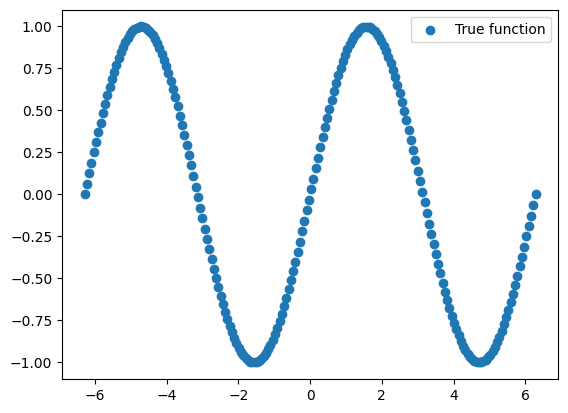

In [11]:
import torch
import matplotlib.pyplot as plt

# generate data
torch.manual_seed(42)  # reproducibility
x = torch.linspace(-2*torch.pi, 2*torch.pi, 200).unsqueeze(1)  # shape (200, 1)
y = torch.sin(x)  # target

# visualize
plt.scatter(x.numpy(), y.numpy(), label="True function")
plt.legend()
plt.show()


In [12]:
#Input layer → hidden layer (ReLU) → output layer

import torch.nn as nn

class SimpleFFN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, output_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # (1 -> 16) #Here there 16 neurons in the hidden layer
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)  # (16 -> 1)
        )

    def forward(self, x):
        return self.net(x)


In [13]:
# create model
model = SimpleFFN(input_dim=1, hidden_dim=16, output_dim=1)

# pick a sample x
x_sample = torch.tensor([[1.0]])  # shape (1,1)
y_pred = model(x_sample)

print("Input:", x_sample.item())
print("Model output (untrained):", y_pred.item())


Input: 1.0
Model output (untrained): 0.9520095586776733


In [14]:
#Setup Loss function and Optimizer
import torch.optim as optim

# loss function
criterion = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [15]:
# training loop
epochs = 1000
for epoch in range(epochs):
    # forward pass
    y_pred = model(x)
    
    # loss
    loss = criterion(y_pred, y)
    
    # backward pass
    optimizer.zero_grad()   # reset gradients
    loss.backward()         # compute gradients
    optimizer.step()        # update weights
    
    # log every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 100/1000, Loss: 0.2537
Epoch 200/1000, Loss: 0.1558
Epoch 300/1000, Loss: 0.1446
Epoch 400/1000, Loss: 0.1430
Epoch 500/1000, Loss: 0.1416
Epoch 600/1000, Loss: 0.1388
Epoch 700/1000, Loss: 0.1332
Epoch 800/1000, Loss: 0.1224
Epoch 900/1000, Loss: 0.1064
Epoch 1000/1000, Loss: 0.0906


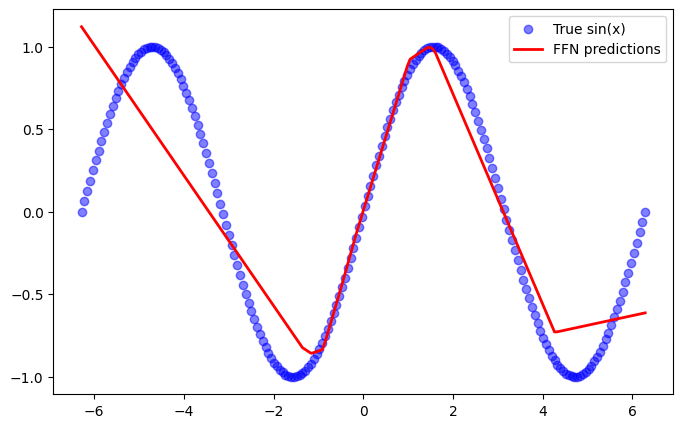

In [16]:
# model predictions after training
with torch.no_grad():  # no gradients needed
    y_pred = model(x)

# plot
plt.figure(figsize=(8,5))
plt.scatter(x.numpy(), y.numpy(), label="True sin(x)", color="blue", alpha=0.5)
plt.plot(x.numpy(), y_pred.numpy(), label="FFN predictions", color="red", linewidth=2)
plt.legend()
plt.show()


# Full Code for an FFN

Epoch 100/10000, Loss: 0.1225
Epoch 200/10000, Loss: 0.0998
Epoch 300/10000, Loss: 0.0811
Epoch 400/10000, Loss: 0.0582
Epoch 500/10000, Loss: 0.0368
Epoch 600/10000, Loss: 0.0216
Epoch 700/10000, Loss: 0.0126
Epoch 800/10000, Loss: 0.0075
Epoch 900/10000, Loss: 0.0049
Epoch 1000/10000, Loss: 0.0035
Epoch 1100/10000, Loss: 0.0024
Epoch 1200/10000, Loss: 0.0019
Epoch 1300/10000, Loss: 0.0015
Epoch 1400/10000, Loss: 0.0013
Epoch 1500/10000, Loss: 0.0012
Epoch 1600/10000, Loss: 0.0010
Epoch 1700/10000, Loss: 0.0010
Epoch 1800/10000, Loss: 0.0009
Epoch 1900/10000, Loss: 0.0009
Epoch 2000/10000, Loss: 0.0008
Epoch 2100/10000, Loss: 0.0008
Epoch 2200/10000, Loss: 0.0008
Epoch 2300/10000, Loss: 0.0007
Epoch 2400/10000, Loss: 0.0007
Epoch 2500/10000, Loss: 0.0030
Epoch 2600/10000, Loss: 0.0009
Epoch 2700/10000, Loss: 0.0008
Epoch 2800/10000, Loss: 0.0007
Epoch 2900/10000, Loss: 0.0009
Epoch 3000/10000, Loss: 0.0009
Epoch 3100/10000, Loss: 0.0008
Epoch 3200/10000, Loss: 0.0016
Epoch 3300/10000,

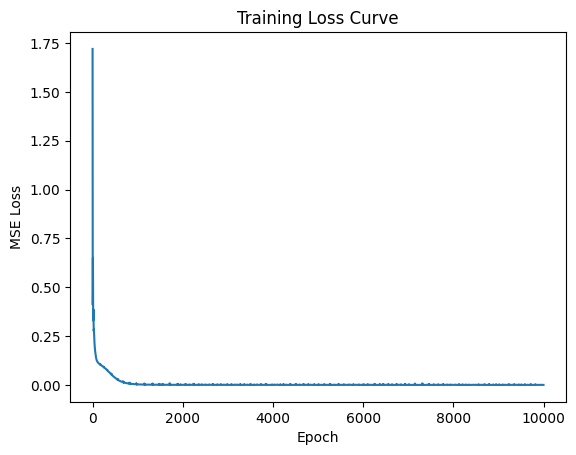

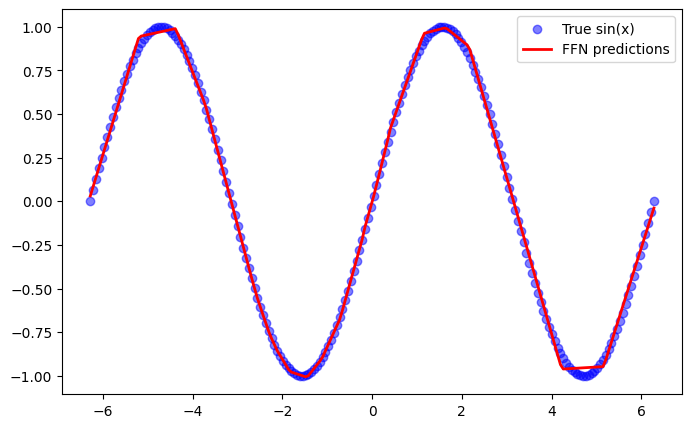

In [17]:
# ---------------------------
# Feedforward Network (FFN) Example
# Task: Learn sin(x)
# ---------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. Dataset
torch.manual_seed(42)
x = torch.linspace(-2*torch.pi, 2*torch.pi, 200).unsqueeze(1)   # shape (200, 1)
y = torch.sin(x)

# 2. Define FFN
class SimpleFFN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleFFN()

# 3. Loss + Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 4. Training loop
epochs = 10000
losses = []

for epoch in range(epochs):
    # forward
    y_pred = model(x)
    loss = criterion(y_pred, y)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# 5. Plot loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.show()

# 6. Plot predictions vs true
with torch.no_grad():
    y_pred = model(x)

plt.figure(figsize=(8,5))
plt.scatter(x.numpy(), y.numpy(), label="True sin(x)", color="blue", alpha=0.5)
plt.plot(x.numpy(), y_pred.numpy(), label="FFN predictions", color="red", linewidth=2)
plt.legend()
plt.show()


# From Basic FFN to Modern FFN

The above was a **basic FFN**. Lately, things have changed a bit — the **heart is still the same**, but modern architectures add some refinements:

---

###  Step A – RMSNorm (Pre-Norm)
- Normalize the input **before** passing into the FFN.  
- Use **RMSNorm** (lighter, used in *LLaMA* / *Mistral*) instead of LayerNorm.  

---

###  Step B – SwiGLU (Modern Gating)
- Replace the plain MLP with **SwiGLU** for richer dynamics.  
- Adjust hidden dimension properly so parameter count ≈ classic 4×.  

---

### Step C – Dropout (Two Places)
- **Inside FFN** (after activation/gating).  
- **After final projection** (residual dropout).  

---

###  Step D – DropPath (Optional, Training Stabilizer)
- Randomly skip whole FFN blocks during training.  
- Helps with regularization in very deep networks.  


# 🔹 RMSNorm (Pre-Norm) — Theory

### LayerNorm (baseline)
$$
\text{LN}(x) = \frac{x - \mu}{\sigma} \cdot \gamma + \beta
$$

- Subtracts the mean $\mu$ and divides by standard deviation $\sigma$ across features.  
- Has learnable parameters: $\gamma$ (scale) and $\beta$ (shift).  
- Works well, but slightly heavier due to mean calculation.  

---

### RMSNorm (modern choice)
$$
\text{RMSNorm}(x) = \frac{x}{\text{RMS}(x)} \cdot \gamma
$$

where  

$$
\text{RMS}(x) = \sqrt{\frac{1}{d} \sum_{i=1}^{d} x_i^2 + \epsilon}
$$

- **No mean subtraction** (lighter than LayerNorm).  
- Only rescales by Root Mean Square (RMS).  
- Uses **scale parameter $\gamma$** (no shift $\beta$).  
- Faster, simpler, and often just as effective.  

---

### Pre-Norm vs Post-Norm
- **Post-Norm (old style, original Transformer):**  
## x → FFN → Norm → (add residual)  (Earlier)
### x → Norm → FFN → (add residual)  (Now)

- **Pre-Norm helps stabilize very deep networks and avoids vanishing gradients.**


✅ Modern FFNs use **RMSNorm in Pre-Norm style**, making them lighter and more stable than the ori

In [19]:
import torch
import torch.nn as nn

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        # learnable scale parameter γ (same size as hidden dimension)
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # compute RMS over last dimension
        rms = x.pow(2).mean(dim=-1, keepdim=True).sqrt()  # shape: (batch, seq, 1)
        x_normed = x / (rms + self.eps)
        return self.scale * x_normed


# 🔹 Modern FFN (Step A: Add RMSNorm Pre-Norm)

In [20]:
import torch
import torch.nn as nn

# custom RMSNorm (from previous step)
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))  # learnable γ

    def forward(self, x):
        rms = x.pow(2).mean(dim=-1, keepdim=True).sqrt()
        x_normed = x / (rms + self.eps)
        return self.scale * x_normed

# FFN with RMSNorm Pre-Norm
class ModernFFN(nn.Module):
    def __init__(self, d_model=16, d_ff=64, dropout=0.1):
        super().__init__()
        self.norm = RMSNorm(d_model)  # Pre-Norm
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),   # will replace with SwiGLU in Step B
            nn.Linear(d_ff, d_model, bias=False),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Pre-Norm
        x_normed = self.norm(x)
        out = self.ffn(x_normed)
        return self.dropout(out)


# Train with RMS Norm

Epoch 100/10000, Loss: 0.4975
Epoch 200/10000, Loss: 0.4975
Epoch 300/10000, Loss: 0.4975
Epoch 400/10000, Loss: 0.4975
Epoch 500/10000, Loss: 0.4975
Epoch 600/10000, Loss: 0.4975
Epoch 700/10000, Loss: 0.4975
Epoch 800/10000, Loss: 0.4975
Epoch 900/10000, Loss: 0.4975
Epoch 1000/10000, Loss: 0.4975
Epoch 1100/10000, Loss: 0.4975
Epoch 1200/10000, Loss: 0.4975
Epoch 1300/10000, Loss: 0.4975
Epoch 1400/10000, Loss: 0.4975
Epoch 1500/10000, Loss: 0.4975
Epoch 1600/10000, Loss: 0.4975
Epoch 1700/10000, Loss: 0.4975
Epoch 1800/10000, Loss: 0.4975
Epoch 1900/10000, Loss: 0.4975
Epoch 2000/10000, Loss: 0.4975
Epoch 2100/10000, Loss: 0.4975
Epoch 2200/10000, Loss: 0.4975
Epoch 2300/10000, Loss: 0.4975
Epoch 2400/10000, Loss: 0.4975
Epoch 2500/10000, Loss: 0.4975
Epoch 2600/10000, Loss: 0.4975
Epoch 2700/10000, Loss: 0.4975
Epoch 2800/10000, Loss: 0.4975
Epoch 2900/10000, Loss: 0.4975
Epoch 3000/10000, Loss: 0.4975
Epoch 3100/10000, Loss: 0.4975
Epoch 3200/10000, Loss: 0.4975
Epoch 3300/10000,

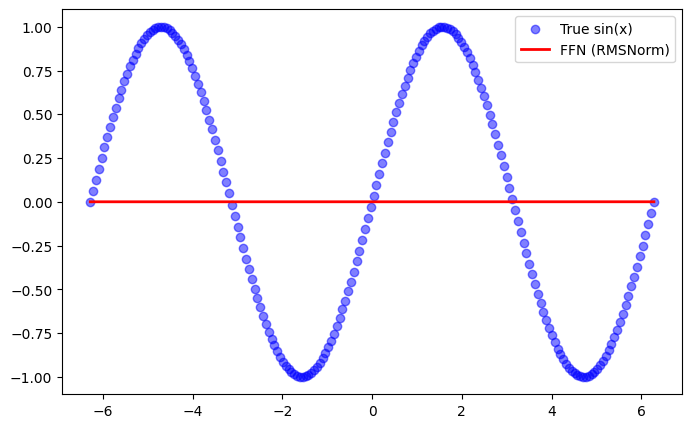

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ---------------------------
# 1. Dataset
# ---------------------------
torch.manual_seed(42)
x = torch.linspace(-2*torch.pi, 2*torch.pi, 200).unsqueeze(1)   # (200,1)
y = torch.sin(x)

# ---------------------------
# 2. RMSNorm definition
# ---------------------------
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))  # γ
    def forward(self, x):
        rms = x.pow(2).mean(dim=-1, keepdim=True).sqrt()
        return self.scale * x / (rms + self.eps)

# ---------------------------
# 3. FFN with RMSNorm Pre-Norm
# ---------------------------
class ModernFFN(nn.Module):
    def __init__(self, d_model=1, d_ff=64, dropout=0.0):
        super().__init__()
        self.norm = RMSNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=True),  # keep bias for toy task
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=True),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x_normed = self.norm(x)
        return self.dropout(self.ffn(x_normed))

model = ModernFFN()

# ---------------------------
# 4. Loss + Optimizer
# ---------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ---------------------------
# 5. Training loop
# ---------------------------
epochs = 10000
losses = []

for epoch in range(epochs):
    y_pred = model(x)
    loss = criterion(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# ---------------------------
# 6. Plot predictions
# ---------------------------
with torch.no_grad():
    y_pred = model(x)

plt.figure(figsize=(8,5))
plt.scatter(x.numpy(), y.numpy(), label="True sin(x)", color="blue", alpha=0.5)
plt.plot(x.numpy(), y_pred.numpy(), label="FFN (RMSNorm)", color="red", linewidth=2)
plt.legend()
plt.show()


# ⚠️ Why RMSNorm Fails in Our Tiny 1D Toy Example

- In our setup, the input dimension is only **1**.  
- RMSNorm computes:
  $$
  \text{RMS}(x) = \sqrt{\frac{1}{d}\sum_{i=1}^d x_i^2 + \epsilon}
  $$
  When $d=1$, this reduces to just:
  $$
  \text{RMS}(x) \approx |x|
  $$
- So RMSNorm normalizes every input to roughly **±1**, destroying the scale information the model needs to learn $\sin(x)$.  

---

### Additional Factors
- We also disabled **biases** in Linear layers (bias=False) for modern FFNs, but in a **tiny regression task**, biases are actually needed to shift outputs.  
- **Dropout** (even small) can harm training when the network and dataset are this small.  

---

### ✅ Takeaway
- RMSNorm is designed for **high-dimensional embeddings** (e.g., 512, 1024, 4096 in Transformers).  
- In such cases, the RMS over many features preserves enough information while stabilizing training.  
- In our **1D toy case**, RMSNorm collapses variation → the model outputs a flat line.  

👉 For demonstration of RMSNorm, we should use **larger embedding sizes** (like in Transformers), not 1D toy regressions.


# Bahdanau Attention (2014) — Neural Machine Translation

**Problem (pre-attention):**  
In vanilla encoder–decoder RNNs, the entire input sequence was compressed into a **single fixed-length vector** (the final hidden state of the encoder).  
- This worked for short sentences but failed badly for long ones.  
- Information from early words was lost.  
- Translation quality degraded as input length increased.  

---

### Core Idea (Bahdanau et al., 2014)
Instead of relying only on the last encoder hidden state, let the decoder:
1. **Keep all encoder hidden states** \( h_1, h_2, …, h_T \).  
2. At each decoder step \( t \), **decide which encoder states to focus on** by computing an *alignment score*.  
3. Use these scores to build a weighted average of encoder states = **context vector** \( c_t \).  
4. Combine \( c_t \) with the decoder state \( s_t \) to make the next prediction.  

This is called **soft alignment** because it distributes attention weights across all input words.

---

### Step-by-Step Math

1. **Alignment scores**  
For each decoder step \( t \), compare decoder hidden state \( s_t \) with every encoder hidden state \( h_i \):  

$$
e_{t,i} = v_a^\top \tanh(W_s s_t + W_h h_i)
$$  

- \( W_s, W_h, v_a \) are learnable parameters.  
- \( e_{t,i} \) = relevance of encoder word \( i \) when predicting the next output.  

---

2. **Attention weights (softmax normalization)**  

$$
\alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_j \exp(e_{t,j})}
$$  

Now \(\alpha_{t,i}\) indicates *how much attention to give* to word \( i \).  

---

3. **Context vector**  

$$
c_t = \sum_i \alpha_{t,i} \cdot h_i
$$  

This is a dynamic summary of the source, focused on what matters for step \( t \).  

---

4. **Attended state**  

$$
\tilde{s}_t = \tanh(W_c [s_t ; c_t])
$$  

This merges “what the decoder knows so far” with “what it just focused on.”  

---

5. **Output prediction**  

$$
y_t = \text{softmax}(W_o \tilde{s}_t)
$$  

---

### Intuition Recap
- Encoder: produces a hidden state for each input word.  
- Decoder step \( t \):  
  - Computes alignment with each encoder state.  
  - Builds a context vector as a weighted blend.  
  - Uses this to predict the next word.  

**Key difference from pre-attention:** Instead of a single static summary, the decoder dynamically decides *where to look* at every step.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size, attn_size):
        super().__init__()
        # Linear layers for computing alignment scores
        self.W_s = nn.Linear(hidden_size, attn_size)   # for decoder state
        self.W_h = nn.Linear(hidden_size, attn_size)   # for encoder states
        self.v_a = nn.Linear(attn_size, 1, bias=False) # score to scalar

    def forward(self, decoder_state, encoder_outputs):
        """
        decoder_state: (batch, hidden_size) at time t
        encoder_outputs: (batch, seq_len, hidden_size) for all encoder steps
        """
        # (batch, 1, hidden_size)
        dec = decoder_state.unsqueeze(1)

        # Project both
        dec_proj = self.W_s(dec)                        # (batch, 1, attn_size)
        enc_proj = self.W_h(encoder_outputs)            # (batch, seq_len, attn_size)

        # Broadcast addition + tanh
        scores = self.v_a(torch.tanh(dec_proj + enc_proj))  # (batch, seq_len, 1)

        # Drop the last dim
        scores = scores.squeeze(-1)  # (batch, seq_len)

        # Softmax over seq_len → attention weights
        attn_weights = F.softmax(scores, dim=1)  # (batch, seq_len)

        # Weighted sum of encoder outputs → context vector
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs) 
        context = context.squeeze(1)  # (batch, hidden_size)

        return context, attn_weights

# ----------------------------
# Demo
# ----------------------------
batch_size = 1
seq_len = 3
hidden_size = 8
attn_size = 6

# Fake encoder outputs (like for "I love India")
encoder_outputs = torch.randn(batch_size, seq_len, hidden_size)

# Fake decoder hidden state (at some step t)
decoder_state = torch.randn(batch_size, hidden_size)

# Run attention
attention = BahdanauAttention(hidden_size, attn_size)
context, attn_weights = attention(decoder_state, encoder_outputs)

print("Attention weights:", attn_weights)
print("Context vector:", context)


# Luong (2015) Attention

# Bahdanau (2014) vs. Luong (2015) Attention

---

### 🌱 Bahdanau Attention (Additive Attention, 2014)

**Key idea:** Use a small feed-forward neural network to compute *alignment scores*.  
- He called this **additive attention**.

**Steps:**
1. **Alignment score:**
   $$
   e_{t,i} = v_a^\top \tanh(W_s s_t + W_h h_i)
   $$
   - Learnable parameters: $W_s, W_h, v_a$  
   - Nonlinear scoring function.

2. **Attention weights:**
   $$
   \alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_j \exp(e_{t,j})}
   $$

3. **Context vector:**
   $$
   c_t = \sum_i \alpha_{t,i} h_i
   $$

4. **Combine context + decoder state:**
   $$
   \tilde{s}_t = \tanh(W_c [s_t ; c_t])
   $$

5. **Predict next word:**
   $$
   y_t = \text{softmax}(W_o \tilde{s}_t)
   $$

---

### 🌿 Luong Attention (Multiplicative Attention, 2015)

**Key idea:** Simplify scoring with similarity measures.  
- He called this **multiplicative attention**.  
- Two main scoring variants:  
  - **Dot:** $e_{t,i} = s_t^\top h_i$  
  - **General:** $e_{t,i} = s_t^\top W h_i$

**Steps:**
1. **Alignment score (dot/general):**
   - Dot product or linear transform, no extra hidden layer.

2. **Attention weights:** *(same as Bahdanau)*  
   $$
   \alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_j \exp(e_{t,j})}
   $$

3. **Context vector:** *(same as Bahdanau)*  
   $$
   c_t = \sum_i \alpha_{t,i} h_i
   $$

4. **Combine context + decoder state:**  
   $$
   \tilde{h}_t = \tanh(W_c [c_t ; s_t])
   $$

5. **Predict next word:** *(same as Bahdanau)*  
   $$
   y_t = \text{softmax}(W_o \tilde{h}_t)
   $$

---

### 🌍 Main Differences

- **Scoring function:**  
  - Bahdanau → additive MLP with nonlinearity.  
  - Luong → dot product (fast) or linear “general” form.  

- **Efficiency:**  
  - Bahdanau slower, more parameters.  
  - Luong lighter, faster, easier to scale.  

- **Local vs. global:**  
  - Luong also introduced **local attention**, focusing only on a window of encoder states, improving speed on long sequences.  

**Shared parts:**  
Both compute attention weights → context vector → combine with decoder state → predict next word.


# Global vs Local Attention (Luong, 2015)

---

### 🌍 Global Attention
- At each decoder step \(t\), compute alignment scores between decoder state \(s_t\) and **all encoder states** \(h_1, h_2, …, h_S\).  
- Apply softmax over the full sequence to get attention weights.  
- Build context vector as weighted sum of **all encoder states**.  
- Advantage: model can attend anywhere.  
- Disadvantage: expensive for long sequences (\(O(S)\) per step) and focus may spread too thin.

---

### 🔍 Local Attention
- Predict a **center position** \(p_t\) in the source sequence.  
  - **Monotonic (local-m):**  
    $$
    p_t = t
    $$
  - **Predictive (local-p):**  
    $$
    p_t = S \cdot \sigma(v_p^\top \tanh(W_p s_t))
    $$
    where a small neural net predicts \(p_t\) from the decoder state.

- Apply a **Gaussian prior** around \(p_t\):  
  $$
  G_{t,i} = \exp\!\Big(-\frac{(i - p_t)^2}{2\sigma^2}\Big)
  $$

- Final unnormalized attention:  
  $$
  \alpha_{t,i} \propto \exp(e_{t,i}) \cdot G_{t,i}
  $$

- Effect: model attends strongly near \(p_t\), but softly includes neighbors.  
- Advantage: cheaper, sharper focus, better for long sequences.  
- Disadvantage: risk of missing distant dependencies if \(p_t\) is predicted poorly.

---

### 🧠 Intuition
- **Global:** a wide searchlight scanning the entire source sentence.  
- **Local:** a focused spotlight predicted by the decoder, softly centered by a Gaussian curve.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # Luong "general" score uses a linear transform of encoder states
        self.W = nn.Linear(hidden_size, hidden_size, bias=False)

    def score(self, decoder_state, encoder_outputs):
        """
        decoder_state: (batch, hidden_size)
        encoder_outputs: (batch, seq_len, hidden_size)
        """
        # (batch, hidden_size) -> (batch, 1, hidden_size)
        dec = decoder_state.unsqueeze(1)
        # Apply linear to encoder outputs (general form)
        enc = self.W(encoder_outputs)  # (batch, seq_len, hidden_size)
        # Dot product along hidden dim
        scores = torch.bmm(dec, enc.transpose(1, 2))  # (batch, 1, seq_len)
        return scores.squeeze(1)  # (batch, seq_len)

    def forward(self, decoder_state, encoder_outputs):
        # Step 1: compute alignment scores
        scores = self.score(decoder_state, encoder_outputs)  # (batch, seq_len)

        # Step 2: softmax -> attention weights
        attn_weights = F.softmax(scores, dim=1)  # (batch, seq_len)

        # Step 3: weighted sum -> context vector
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        context = context.squeeze(1)  # (batch, hidden_size)

        return context, attn_weights

# ----------------------------
# Demo
# ----------------------------
batch_size = 1
seq_len = 3
hidden_size = 8

# Fake encoder outputs (like for "I love India")
encoder_outputs = torch.randn(batch_size, seq_len, hidden_size)

# Fake decoder hidden state (at some step t)
decoder_state = torch.randn(batch_size, hidden_size)

# Run attention
attention = LuongAttention(hidden_size)
context, attn_weights = attention(decoder_state, encoder_outputs)

print("Attention weights:", attn_weights)
print("Context vector:", context)


# Self-Attention (Scaled Dot-Product Attention)

---

### Motivation
- RNNs process tokens **sequentially** → slow, hard to parallelize.  
- Self-Attention lets each token **attend to all others directly** → full parallelism on GPUs.  

---

### Step 1 — Queries, Keys, Values
Each token embedding \(x_i \in \mathbb{R}^d\) is projected into:

$$
q_i = W_Q x_i, \quad k_i = W_K x_i, \quad v_i = W_V x_i
$$

- **Query**: what this token is asking for.  
- **Key**: what this token can offer.  
- **Value**: the actual information to share.  

---

### Step 2 — Similarity Scores
Compare Query of token \(i\) against Keys of all tokens \(j\):

$$
\text{score}(i,j) = \frac{q_i^\top k_j}{\sqrt{d_k}}
$$

Scaling by \(\sqrt{d_k}\) prevents large dot products from destabilizing softmax.

---

### Step 3 — Attention Weights
Convert scores into probabilities:

$$
\alpha_{i,j} = \frac{\exp(\text{score}(i,j))}{\sum_m \exp(\text{score}(i,m))}
$$

\(\alpha_{i,j}\) = how much token \(i\) attends to token \(j\).  

---

### Step 4 — Context Vector
Each token builds a new representation as a weighted sum of Values:

$$
z_i = \sum_j \alpha_{i,j} v_j
$$

---

### Step 5 — Matrix Form
For the whole sequence (length \(n\)):

$$
Q = X W_Q, \quad K = X W_K, \quad V = X W_V
$$

$$
\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right) V
$$

- Output \(Z \in \mathbb{R}^{n \times d_v}\).  
- Each row \(z_i\) = contextual embedding for token \(i\).  

---




import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.embed_size = embed_size
        # Linear projections for Q, K, V
        self.W_Q = nn.Linear(embed_size, embed_size, bias=False)
        self.W_K = nn.Linear(embed_size, embed_size, bias=False)
        self.W_V = nn.Linear(embed_size, embed_size, bias=False)

    def forward(self, X):
        """
        X: (batch, seq_len, embed_size)
        """
        Q = self.W_Q(X)   # (batch, seq_len, embed_size)
        K = self.W_K(X)   # (batch, seq_len, embed_size)
        V = self.W_V(X)   # (batch, seq_len, embed_size)

        # Step 1: Compute similarity scores
        # QK^T -> (batch, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.embed_size ** 0.5)

        # Step 2: Softmax to get attention weights
        attn_weights = F.softmax(scores, dim=-1)  # (batch, seq_len, seq_len)

        # Step 3: Weighted sum with V
        out = torch.matmul(attn_weights, V)  # (batch, seq_len, embed_size)

        return out, attn_weights

# ----------------------------
# Demo
# ----------------------------
batch_size = 1
seq_len = 3
embed_size = 4

# Fake token embeddings ("I", "love", "India")
X = torch.randn(batch_size, seq_len, embed_size)

self_attn = SelfAttention(embed_size)
out, attn_weights = self_attn(X)

print("Attention weights:\n", attn_weights)
print("\nOutput embeddings:\n", out)


# Multi-Head Attention (MHA)

## 🎯 Motivation

- **Single-head attention** learns only one type of relation between tokens
- Language has **multiple simultaneous relations**:
  - Subject–verb dependencies
  - Object–verb relationships  
  - Positional patterns
  - Semantic roles
- **Multi-Head Attention** = multiple attention "specialists" working in parallel

---

## 📐 Mathematical Framework

### Step 1: Per-Head Projections
For each head $i = 1, \ldots, h$, project input embeddings $X \in \mathbb{R}^{n \times d}$:

$$Q^i = XW_Q^i, \quad K^i = XW_K^i, \quad V^i = XW_V^i$$

where $W_Q^i, W_K^i, W_V^i \in \mathbb{R}^{d \times d_k}$ and typically $d_k = \frac{d}{h}$.

### Step 2: Scaled Dot-Product Attention
Each head computes attention independently:

$$Z^i = \text{softmax}\left(\frac{Q^i (K^i)^\top}{\sqrt{d_k}}\right)V^i$$

Output: $Z^i \in \mathbb{R}^{n \times d_v}$ where $d_v = d_k$ typically.

### Step 3: Concatenation
Concatenate all heads along the feature dimension:

$$Z = [Z^1 \,;\, Z^2 \,;\, \ldots \,;\, Z^h] \in \mathbb{R}^{n \times (h \cdot d_v)}$$

### Step 4: Final Linear Projection
Project back to embedding dimension:

$$\text{MHA}(X) = ZW_O$$

where $W_O \in \mathbb{R}^{(h \cdot d_v) \times d}$.

---

## 🔄 Architecture Flow

```
Input Embeddings X ∈ ℝⁿˣᵈ
         │
         ▼
┌─────────────────────────┐
│   Linear Projections    │
│  W_Q^i, W_K^i, W_V^i    │
│    for i = 1...h        │
└─────────────────────────┘
         │
         ▼
┌──────────┬──────────┬──────────┐
│  Head 1  │  Head 2  │  Head h  │
│ ┌──────┐ │ ┌──────┐ │ ┌──────┐ │
│ │Q¹K¹V¹│ │ │Q²K²V²│ │ │QʰKʰVʰ│ │
│ └──────┘ │ └──────┘ │ └──────┘ │
│ Attn(·)  │ Attn(·)  │ Attn(·)  │
└──────────┴──────────┴──────────┘
         │
         ▼
    Concatenate
   [Z¹; Z²; ...; Zʰ]
         │
         ▼
┌─────────────────────────┐
│  Final Linear Layer     │
│        W_O              │
└─────────────────────────┘
         │
         ▼
   MHA Output ∈ ℝⁿˣᵈ
```

---

## 💡 Key Insights

1. **Parallel Processing**: Each head learns different attention patterns simultaneously
2. **Complementary Views**: Heads may specialize in:
   - Syntactic dependencies (subject-verb)
   - Semantic relationships (word meanings)
   - Positional patterns (nearby tokens)
   - Long-range dependencies

3. **Parameter Efficiency**: By using $d_k = d/h$, total parameters ≈ single-head attention

4. **Expressiveness**: $h$ heads can capture $h$ different types of relationships

---

## ⚙️ Implementation Notes

- **Typical values**: $h = 8$ or $h = 12$ in practice
- **Dimension splitting**: $d_k = d_v = d/h$ keeps parameter count manageable  
- **Computational complexity**: $O(n^2 d)$ same as single-head, but with $h$× parallelization
- **Memory**: Stores $h$ attention matrices of size $n \times n$

---

*Next: Implement MHA in PyTorch with shape annotations and visualization!*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super().__init__()
        assert embed_size % num_heads == 0, "embed_size must be divisible by num_heads"
        
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads  # dimension per head

        # Linear projections for Q, K, V
        self.W_Q = nn.Linear(embed_size, embed_size, bias=False)
        self.W_K = nn.Linear(embed_size, embed_size, bias=False)
        self.W_V = nn.Linear(embed_size, embed_size, bias=False)

        # Final linear projection
        self.W_O = nn.Linear(embed_size, embed_size, bias=False)

    def forward(self, X):
        """
        X: (batch, seq_len, embed_size)
        """
        batch_size, seq_len, _ = X.size()

        # Project into Q, K, V
        Q = self.W_Q(X)  # (batch, seq_len, embed_size)
        K = self.W_K(X)
        V = self.W_V(X)

        # Reshape into multiple heads: (batch, num_heads, seq_len, head_dim)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Step 1: Compute scaled dot-product scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        # scores: (batch, num_heads, seq_len, seq_len)

        # Step 2: Softmax
        attn_weights = F.softmax(scores, dim=-1)  # (batch, num_heads, seq_len, seq_len)

        # Step 3: Weighted sum with V
        out = torch.matmul(attn_weights, V)  # (batch, num_heads, seq_len, head_dim)

        # Step 4: Concatenate heads back
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_size)

        # Step 5: Final projection
        out = self.W_O(out)  # (batch, seq_len, embed_size)

        return out, attn_weights

# ----------------------------
# Demo
# ----------------------------
batch_size = 1
seq_len = 4
embed_size = 8
num_heads = 2

# Fake input (4 tokens, each embed_size=8)
X = torch.randn(batch_size, seq_len, embed_size)

mha = MultiHeadAttention(embed_size, num_heads)
out, attn_weights = mha(X)

print("Attention weights shape:", attn_weights.shape)  # (batch, heads, seq_len, seq_len)
print("Output shape:", out.shape)                      # (batch, seq_len, embed_size)


# Final Code for GPT-2

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import time
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np


@dataclass
class TrainingConfig:
    """Training configuration parameters."""
    # Model config
    vocab_size: int = 50257
    max_position_embeddings: int = 512
    n_embd: int = 256
    n_layer: int = 6
    n_head: int = 8
    dropout: float = 0.1
    
    # Training config
    batch_size: int = 8
    learning_rate: float = 3e-4
    max_epochs: int = 10
    warmup_steps: int = 1000
    max_steps: Optional[int] = None
    gradient_accumulation_steps: int = 4
    weight_decay: float = 0.01
    max_grad_norm: float = 1.0
    
    # Data config
    block_size: int = 256  # sequence length for training
    
    # Logging
    eval_interval: int = 500
    log_interval: int = 100
    save_interval: int = 1000


class WikiTextDataset(Dataset):
    """Dataset for WikiText-2 with proper tokenization and chunking."""
    
    def __init__(self, texts: List[str], tokenizer, block_size: int = 256):
        self.tokenizer = tokenizer
        self.block_size = block_size
        
        # Tokenize all texts and concatenate
        print("Tokenizing dataset...")
        all_tokens = []
        
        for text in texts:
            if text.strip():  # Skip empty lines
                tokens = tokenizer.encode(text.strip())
                all_tokens.extend(tokens)
                all_tokens.append(tokenizer.eos_token_id)  # Add EOS between articles
        
        self.tokens = torch.tensor(all_tokens, dtype=torch.long)
        print(f"Dataset has {len(self.tokens)} tokens")
        
        # Calculate number of samples
        self.num_samples = max(0, len(self.tokens) - block_size)
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Get a chunk of tokens
        chunk = self.tokens[idx:idx + self.block_size + 1]
        
        # Input and target (shifted by 1)
        x = chunk[:-1]
        y = chunk[1:]
        
        return x, y


class TrainingManager:
    """Manages the training process."""
    
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('gpt2')
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        # Load and prepare data
        self.train_loader, self.val_loader = self._prepare_data()
        
        # Initialize model
        model_config = self._create_model_config()
        self.model = GPT2Model(model_config).to(self.device)
        print(f"Model has {self.model.get_num_params():,} parameters")
        
        # Initialize optimizer and scheduler
        self.optimizer = self._create_optimizer()
        self.scheduler = self._create_scheduler()
        
        # Training state
        self.step = 0
        self.epoch = 0
        self.best_val_loss = float('inf')
        self.train_losses = []
        self.val_losses = []
    
    def _create_model_config(self):
        """Create model configuration from training config."""
        from types import SimpleNamespace
        return SimpleNamespace(
            vocab_size=self.config.vocab_size,
            max_position_embeddings=self.config.max_position_embeddings,
            n_embd=self.config.n_embd,
            n_layer=self.config.n_layer,
            n_head=self.config.n_head,
            n_inner=None,
            dropout=self.config.dropout,
            layer_norm_epsilon=1e-5,
            use_bias=True
        )
    
    def _prepare_data(self) -> Tuple[DataLoader, DataLoader]:
        """Load and prepare WikiText-2 dataset."""
        print("Loading WikiText-2 dataset...")
        dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
        
        # Create datasets
        train_texts = [item['text'] for item in dataset['train'] if item['text'].strip()]
        val_texts = [item['text'] for item in dataset['validation'] if item['text'].strip()]
        
        train_dataset = WikiTextDataset(train_texts, self.tokenizer, self.config.block_size)
        val_dataset = WikiTextDataset(val_texts, self.tokenizer, self.config.block_size)
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        print(f"Train dataset: {len(train_dataset)} samples")
        print(f"Val dataset: {len(val_dataset)} samples")
        
        return train_loader, val_loader
    
    def _create_optimizer(self) -> optim.Optimizer:
        """Create AdamW optimizer with weight decay."""
        # Separate parameters for weight decay
        decay_params = []
        no_decay_params = []
        
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                if any(nd in name for nd in ['bias', 'ln', 'norm']):
                    no_decay_params.append(param)
                else:
                    decay_params.append(param)
        
        optimizer_groups = [
            {'params': decay_params, 'weight_decay': self.config.weight_decay},
            {'params': no_decay_params, 'weight_decay': 0.0}
        ]
        
        return optim.AdamW(optimizer_groups, lr=self.config.learning_rate)
    
    def _create_scheduler(self):
        """Create learning rate scheduler with warmup."""
        def lr_lambda(step):
            if step < self.config.warmup_steps:
                return step / self.config.warmup_steps
            return 1.0
        
        return optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda)
    
    def train_step(self, batch) -> float:
        """Single training step."""
        self.model.train()
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        
        # Forward pass
        outputs = self.model(x, labels=y)
        loss = outputs['loss']
        
        # Scale loss for gradient accumulation
        loss = loss / self.config.gradient_accumulation_steps
        
        # Backward pass
        loss.backward()
        
        return loss.item() * self.config.gradient_accumulation_steps
    
    def evaluate(self) -> float:
        """Evaluate model on validation set."""
        self.model.eval()
        total_loss = 0
        num_batches = 0
        
        with torch.no_grad():
            for batch in self.val_loader:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)
                
                outputs = self.model(x, labels=y)
                loss = outputs['loss']
                
                total_loss += loss.item()
                num_batches += 1
                
                # Limit evaluation for faster training
                if num_batches >= 50:
                    break
        
        return total_loss / num_batches
    
    def save_checkpoint(self, filepath: str):
        """Save training checkpoint."""
        checkpoint = {
            'step': self.step,
            'epoch': self.epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_val_loss': self.best_val_loss,
            'config': self.config
        }
        torch.save(checkpoint, filepath)
    
    def generate_sample(self, prompt: str = "The", max_tokens: int = 50) -> str:
        """Generate a sample text during training."""
        self.model.eval()
        
        # Tokenize prompt
        input_ids = torch.tensor([self.tokenizer.encode(prompt)]).to(self.device)
        
        # Generate
        with torch.no_grad():
            generated = self.model.generate(
                input_ids,
                max_new_tokens=max_tokens,
                temperature=0.8,
                do_sample=True
            )
        
        # Decode
        generated_text = self.tokenizer.decode(generated[0], skip_special_tokens=True)
        return generated_text
    
    def train(self):
        """Main training loop."""
        print("Starting training...")
        print(f"Device: {self.device}")
        print(f"Model parameters: {self.model.get_num_params():,}")
        
        start_time = time.time()
        accumulated_loss = 0
        
        for epoch in range(self.config.max_epochs):
            self.epoch = epoch
            
            for batch_idx, batch in enumerate(self.train_loader):
                # Training step
                loss = self.train_step(batch)
                accumulated_loss += loss
                
                # Update parameters every gradient_accumulation_steps
                if (batch_idx + 1) % self.config.gradient_accumulation_steps == 0:
                    # Gradient clipping
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(),
                        self.config.max_grad_norm
                    )
                    
                    # Optimizer step
                    self.optimizer.step()
                    self.scheduler.step()
                    self.optimizer.zero_grad()
                    
                    self.step += 1
                    
                    # Logging
                    if self.step % self.config.log_interval == 0:
                        avg_loss = accumulated_loss / self.config.log_interval
                        self.train_losses.append(avg_loss)
                        
                        lr = self.scheduler.get_last_lr()[0]
                        elapsed = time.time() - start_time
                        
                        print(f"Step {self.step:5d} | "
                              f"Epoch {epoch:2d} | "
                              f"Loss: {avg_loss:.4f} | "
                              f"LR: {lr:.2e} | "
                              f"Time: {elapsed:.1f}s")
                        
                        accumulated_loss = 0
                    
                    # Evaluation
                    if self.step % self.config.eval_interval == 0:
                        val_loss = self.evaluate()
                        self.val_losses.append(val_loss)
                        
                        print(f"Validation loss: {val_loss:.4f}")
                        
                        # Save best model
                        if val_loss < self.best_val_loss:
                            self.best_val_loss = val_loss
                            self.save_checkpoint(f"best_model_step_{self.step}.pt")
                            print(f"New best model saved! Val loss: {val_loss:.4f}")
                        
                        # Generate sample
                        sample = self.generate_sample("The future of artificial intelligence")
                        print(f"Sample: {sample[:100]}...")
                        print("-" * 80)
                    
                    # Save checkpoint
                    if self.step % self.config.save_interval == 0:
                        self.save_checkpoint(f"checkpoint_step_{self.step}.pt")
                    
                    # Early stopping
                    if self.config.max_steps and self.step >= self.config.max_steps:
                        print(f"Reached max steps ({self.config.max_steps})")
                        return
        
        print("Training completed!")
        self.save_checkpoint("final_model.pt")
    
    def plot_losses(self):
        """Plot training and validation losses."""
        plt.figure(figsize=(12, 5))
        
        # Training loss
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses)
        plt.title('Training Loss')
        plt.xlabel('Steps (x100)')
        plt.ylabel('Loss')
        plt.grid(True)
        
        # Validation loss
        plt.subplot(1, 2, 2)
        plt.plot(self.val_losses)
        plt.title('Validation Loss')
        plt.xlabel('Evaluations')
        plt.ylabel('Loss')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()


# Simplified GPT-2 model (use your full implementation)
class GPT2Model(nn.Module):
    """Simplified GPT-2 for training demo."""
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Embeddings
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.max_position_embeddings, config.n_embd)
        self.drop = nn.Dropout(config.dropout)
        
        # Transformer blocks
        self.h = nn.ModuleList([
            TransformerBlock(config) for _ in range(config.n_layer)
        ])
        
        # Final norm and head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        # Tie weights
        self.lm_head.weight = self.wte.weight
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, input_ids, labels=None):
        b, t = input_ids.size()
        pos = torch.arange(0, t, device=input_ids.device).unsqueeze(0)
        
        tok_emb = self.wte(input_ids)
        pos_emb = self.wpe(pos)
        x = self.drop(tok_emb + pos_emb)
        
        for block in self.h:
            x = block(x)
        
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        
        return {'logits': logits, 'loss': loss}
    
    def generate(self, input_ids, max_new_tokens=50, temperature=1.0, do_sample=True):
        self.eval()
        with torch.no_grad():
            for _ in range(max_new_tokens):
                outputs = self.forward(input_ids)
                logits = outputs['logits'][:, -1, :] / temperature
                
                if do_sample:
                    probs = torch.softmax(logits, dim=-1)
                    next_token = torch.multinomial(probs, num_samples=1)
                else:
                    next_token = torch.argmax(logits, dim=-1, keepdim=True)
                
                input_ids = torch.cat([input_ids, next_token], dim=1)
        
        return input_ids
    
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = config.n_embd // config.n_head
        
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)
        
        self.register_buffer("causal_mask", torch.tril(torch.ones(config.max_position_embeddings, config.max_position_embeddings)).view(1, 1, config.max_position_embeddings, config.max_position_embeddings))
    
    def forward(self, x):
        B, T, C = x.size()
        
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_dim))
        att = att.masked_fill(self.causal_mask[:, :, :T, :T] == 0, float('-inf'))
        att = torch.softmax(att, dim=-1)
        att = self.dropout(att)
        
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        
        return self.c_proj(y)


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, x):
        x = self.c_fc(x)
        x = torch.nn.functional.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


# ================================
# Main Training Script
# ================================

def main():
    """Main training function."""
    # Create training configuration
    config = TrainingConfig(
        # Model config (small for quick training)
        n_embd=256,
        n_layer=6,
        n_head=8,
        
        # Training config
        batch_size=4,  # Small batch for demo
        learning_rate=1e-4,
        max_epochs=3,
        warmup_steps=500,
        max_steps=20000,  # Limit for demo
        gradient_accumulation_steps=2,
        
        # Data config
        block_size=128,  # Smaller sequences for faster training
        
        # Logging
        eval_interval=200,
        log_interval=50,
        save_interval=500
    )
    
    # Create trainer and start training
    trainer = TrainingManager(config)
    trainer.train()
    
    # Plot results
    trainer.plot_losses()
    
    # Final evaluation
    print("\nFinal Evaluation:")
    final_val_loss = trainer.evaluate()
    print(f"Final validation loss: {final_val_loss:.4f}")
    
    # Generate some samples
    print("\nGenerated Samples:")
    for prompt in ["The", "In the future", "Artificial intelligence"]:
        sample = trainer.generate_sample(prompt, max_tokens=30)
        print(f"Prompt: '{prompt}' -> {sample}")


if __name__ == "__main__":
    main()

Using device: cuda
Loading WikiText-2 dataset...
Tokenizing dataset...
Dataset has 2370805 tokens
Tokenizing dataset...
Dataset has 245104 tokens
Train dataset: 2370677 samples
Val dataset: 244976 samples
Model has 17,735,936 parameters
Starting training...
Device: cuda
Model parameters: 17,735,936


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step    50 | Epoch  0 | Loss: 21.5291 | LR: 1.00e-05 | Time: 3.4s
Step   100 | Epoch  0 | Loss: 20.7539 | LR: 2.00e-05 | Time: 6.6s
Step   150 | Epoch  0 | Loss: 20.0219 | LR: 3.00e-05 | Time: 9.7s
Step   200 | Epoch  0 | Loss: 19.1714 | LR: 4.00e-05 | Time: 12.8s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 9.3540
New best model saved! Val loss: 9.3540
Sample: The future of artificial intelligence keyboard pregn whereabouts logic meetsG base priesthoodSales s...
--------------------------------------------------------------------------------
Step   250 | Epoch  0 | Loss: 18.1886 | LR: 5.00e-05 | Time: 17.0s
Step   300 | Epoch  0 | Loss: 17.1693 | LR: 6.00e-05 | Time: 20.1s
Step   350 | Epoch  0 | Loss: 16.1761 | LR: 7.00e-05 | Time: 23.2s
Step   400 | Epoch  0 | Loss: 15.3741 | LR: 8.00e-05 | Time: 26.3s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 7.5773
New best model saved! Val loss: 7.5773
Sample: The future of artificial intelligence , a the Salam ( publishedSoon officers be of religious itself ...
--------------------------------------------------------------------------------
Step   450 | Epoch  0 | Loss: 15.0677 | LR: 9.00e-05 | Time: 30.4s
Step   500 | Epoch  0 | Loss: 14.9407 | LR: 1.00e-04 | Time: 33.5s
Step   550 | Epoch  0 | Loss: 14.8054 | LR: 1.00e-04 | Time: 36.9s
Step   600 | Epoch  0 | Loss: 14.7821 | LR: 1.00e-04 | Time: 40.0s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 7.3219
New best model saved! Val loss: 7.3219
Sample: The future of artificial intelligence In the of chorus the of is = and were a . through , the . Marc...
--------------------------------------------------------------------------------
Step   650 | Epoch  0 | Loss: 14.7819 | LR: 1.00e-04 | Time: 44.2s
Step   700 | Epoch  0 | Loss: 14.7473 | LR: 1.00e-04 | Time: 47.3s
Step   750 | Epoch  0 | Loss: 14.6782 | LR: 1.00e-04 | Time: 50.4s
Step   800 | Epoch  0 | Loss: 14.6826 | LR: 1.00e-04 | Time: 53.4s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 7.2024
New best model saved! Val loss: 7.2024
Sample: The future of artificial intelligence , , " with of " the – which game the the of , place ' occurs t...
--------------------------------------------------------------------------------
Step   850 | Epoch  0 | Loss: 14.6465 | LR: 1.00e-04 | Time: 57.5s
Step   900 | Epoch  0 | Loss: 14.5870 | LR: 1.00e-04 | Time: 60.6s
Step   950 | Epoch  0 | Loss: 14.5163 | LR: 1.00e-04 | Time: 63.7s
Step  1000 | Epoch  0 | Loss: 14.3928 | LR: 1.00e-04 | Time: 66.8s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 7.0244
New best model saved! Val loss: 7.0244
Sample: The future of artificial intelligence the . today squadron , , theores the , achieves NY a @@ make a...
--------------------------------------------------------------------------------
Step  1050 | Epoch  0 | Loss: 14.4742 | LR: 1.00e-04 | Time: 71.4s
Step  1100 | Epoch  0 | Loss: 14.4456 | LR: 1.00e-04 | Time: 74.6s
Step  1150 | Epoch  0 | Loss: 14.4160 | LR: 1.00e-04 | Time: 77.6s
Step  1200 | Epoch  0 | Loss: 14.4106 | LR: 1.00e-04 | Time: 80.7s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.9527
New best model saved! Val loss: 6.9527
Sample: The future of artificial intelligences the to the G . also modern of along this these to visible ran...
--------------------------------------------------------------------------------
Step  1250 | Epoch  0 | Loss: 14.2574 | LR: 1.00e-04 | Time: 85.0s
Step  1300 | Epoch  0 | Loss: 14.2753 | LR: 1.00e-04 | Time: 88.2s
Step  1350 | Epoch  0 | Loss: 14.2351 | LR: 1.00e-04 | Time: 91.3s
Step  1400 | Epoch  0 | Loss: 14.2299 | LR: 1.00e-04 | Time: 94.5s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.8442
New best model saved! Val loss: 6.8442
Sample: The future of artificial intelligence .On the , their in 1 0..il Fraz riverid , this ) 11 – It avail...
--------------------------------------------------------------------------------
Step  1450 | Epoch  0 | Loss: 14.2315 | LR: 1.00e-04 | Time: 98.7s
Step  1500 | Epoch  0 | Loss: 14.1757 | LR: 1.00e-04 | Time: 101.9s
Step  1550 | Epoch  0 | Loss: 14.2133 | LR: 1.00e-04 | Time: 105.3s
Step  1600 | Epoch  0 | Loss: 14.1930 | LR: 1.00e-04 | Time: 108.4s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.7878
New best model saved! Val loss: 6.7878
Sample: The future of artificial intelligence the System a for best .= = crew = = = == = = critic over dedic...
--------------------------------------------------------------------------------
Step  1650 | Epoch  0 | Loss: 14.1179 | LR: 1.00e-04 | Time: 112.6s
Step  1700 | Epoch  0 | Loss: 14.1379 | LR: 1.00e-04 | Time: 115.8s
Step  1750 | Epoch  0 | Loss: 14.1500 | LR: 1.00e-04 | Time: 118.9s
Step  1800 | Epoch  0 | Loss: 14.1100 | LR: 1.00e-04 | Time: 122.0s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.7356
New best model saved! Val loss: 6.7356
Sample: The future of artificial intelligence . hour first of , they the , the of family the Red was , were ...
--------------------------------------------------------------------------------
Step  1850 | Epoch  0 | Loss: 14.0068 | LR: 1.00e-04 | Time: 126.2s
Step  1900 | Epoch  0 | Loss: 13.9239 | LR: 1.00e-04 | Time: 129.3s
Step  1950 | Epoch  0 | Loss: 13.9221 | LR: 1.00e-04 | Time: 132.4s
Step  2000 | Epoch  0 | Loss: 13.9798 | LR: 1.00e-04 | Time: 135.4s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.7300
New best model saved! Val loss: 6.7300
Sample: The future of artificial intelligence the " " Ay imper video " is at ' " the reasons the at "= = Dyl...
--------------------------------------------------------------------------------
Step  2050 | Epoch  0 | Loss: 14.0164 | LR: 1.00e-04 | Time: 140.0s
Step  2100 | Epoch  0 | Loss: 13.9296 | LR: 1.00e-04 | Time: 143.1s
Step  2150 | Epoch  0 | Loss: 13.9021 | LR: 1.00e-04 | Time: 146.2s
Step  2200 | Epoch  0 | Loss: 13.9285 | LR: 1.00e-04 | Time: 148.5s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.6563
New best model saved! Val loss: 6.6563
Sample: The future of artificial intelligence of .In , theory several , , filmana afterman the of Tra role ....
--------------------------------------------------------------------------------
Step  2250 | Epoch  0 | Loss: 13.8127 | LR: 1.00e-04 | Time: 152.0s
Step  2300 | Epoch  0 | Loss: 13.8206 | LR: 1.00e-04 | Time: 155.2s
Step  2350 | Epoch  0 | Loss: 13.8274 | LR: 1.00e-04 | Time: 158.3s
Step  2400 | Epoch  0 | Loss: 13.7707 | LR: 1.00e-04 | Time: 161.4s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.6133
New best model saved! Val loss: 6.6133
Sample: The future of artificial intelligence to both . white on general as , well the of son the of US , , ...
--------------------------------------------------------------------------------
Step  2450 | Epoch  0 | Loss: 13.7458 | LR: 1.00e-04 | Time: 165.5s
Step  2500 | Epoch  0 | Loss: 13.7566 | LR: 1.00e-04 | Time: 168.6s
Step  2550 | Epoch  0 | Loss: 13.7430 | LR: 1.00e-04 | Time: 171.8s
Step  2600 | Epoch  0 | Loss: 13.7379 | LR: 1.00e-04 | Time: 174.9s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.5358
New best model saved! Val loss: 6.5358
Sample: The future of artificial intelligence opposite of and the ofo deities Japanese or . are in torpedo o...
--------------------------------------------------------------------------------
Step  2650 | Epoch  0 | Loss: 13.7503 | LR: 1.00e-04 | Time: 179.1s
Step  2700 | Epoch  0 | Loss: 13.7615 | LR: 1.00e-04 | Time: 182.2s
Step  2750 | Epoch  0 | Loss: 13.6229 | LR: 1.00e-04 | Time: 185.4s
Step  2800 | Epoch  0 | Loss: 13.6688 | LR: 1.00e-04 | Time: 188.5s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.4873
New best model saved! Val loss: 6.4873
Sample: The future of artificial intelligence and did not to , two and to to a of . the of same , considered...
--------------------------------------------------------------------------------
Step  2850 | Epoch  0 | Loss: 13.6923 | LR: 1.00e-04 | Time: 192.8s
Step  2900 | Epoch  0 | Loss: 13.6440 | LR: 1.00e-04 | Time: 195.9s
Step  2950 | Epoch  0 | Loss: 13.6918 | LR: 1.00e-04 | Time: 198.9s
Step  3000 | Epoch  0 | Loss: 13.5061 | LR: 1.00e-04 | Time: 202.0s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.4027
New best model saved! Val loss: 6.4027
Sample: The future of artificial intelligence the of , were by , both and on film a first of , by ,asc , a i...
--------------------------------------------------------------------------------
Step  3050 | Epoch  0 | Loss: 13.5641 | LR: 1.00e-04 | Time: 206.4s
Step  3100 | Epoch  0 | Loss: 13.5265 | LR: 1.00e-04 | Time: 209.2s
Step  3150 | Epoch  0 | Loss: 13.4967 | LR: 1.00e-04 | Time: 211.9s
Step  3200 | Epoch  0 | Loss: 13.5059 | LR: 1.00e-04 | Time: 214.4s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.3822
New best model saved! Val loss: 6.3822
Sample: The future of artificial intelligence " " " " " " " " " " " " " " and " episode was " Thean and in ,...
--------------------------------------------------------------------------------
Step  3250 | Epoch  0 | Loss: 13.5882 | LR: 1.00e-04 | Time: 218.4s
Step  3300 | Epoch  0 | Loss: 13.5397 | LR: 1.00e-04 | Time: 220.9s
Step  3350 | Epoch  0 | Loss: 13.4613 | LR: 1.00e-04 | Time: 223.4s
Step  3400 | Epoch  0 | Loss: 13.4920 | LR: 1.00e-04 | Time: 226.0s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.3685
New best model saved! Val loss: 6.3685
Sample: The future of artificial intelligence the of that the of its of your The are .= = = =After of " " = ...
--------------------------------------------------------------------------------
Step  3450 | Epoch  0 | Loss: 13.4517 | LR: 1.00e-04 | Time: 230.3s
Step  3500 | Epoch  0 | Loss: 13.4754 | LR: 1.00e-04 | Time: 233.4s
Step  3550 | Epoch  0 | Loss: 13.4011 | LR: 1.00e-04 | Time: 236.7s
Step  3600 | Epoch  0 | Loss: 13.3180 | LR: 1.00e-04 | Time: 239.7s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.3051
New best model saved! Val loss: 6.3051
Sample: The future of artificial intelligenceise the ofcriptions theated the of and the ofub , the of to way...
--------------------------------------------------------------------------------
Step  3650 | Epoch  0 | Loss: 13.4237 | LR: 1.00e-04 | Time: 243.8s
Step  3700 | Epoch  0 | Loss: 13.3571 | LR: 1.00e-04 | Time: 246.9s
Step  3750 | Epoch  0 | Loss: 13.3368 | LR: 1.00e-04 | Time: 249.9s
Step  3800 | Epoch  0 | Loss: 13.3201 | LR: 1.00e-04 | Time: 252.9s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.2503
New best model saved! Val loss: 6.2503
Sample: The future of artificial intelligence by the of until , both , the system a of Britishedar and as ob...
--------------------------------------------------------------------------------
Step  3850 | Epoch  0 | Loss: 13.3584 | LR: 1.00e-04 | Time: 257.0s
Step  3900 | Epoch  0 | Loss: 13.3560 | LR: 1.00e-04 | Time: 260.1s
Step  3950 | Epoch  0 | Loss: 13.3500 | LR: 1.00e-04 | Time: 263.1s
Step  4000 | Epoch  0 | Loss: 13.2941 | LR: 1.00e-04 | Time: 266.1s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.2501
New best model saved! Val loss: 6.2501
Sample: The future of artificial intelligence the of of good and solution this of Dream in " episode = Servi...
--------------------------------------------------------------------------------
Step  4050 | Epoch  0 | Loss: 13.3248 | LR: 1.00e-04 | Time: 270.4s
Step  4100 | Epoch  0 | Loss: 13.3778 | LR: 1.00e-04 | Time: 273.5s
Step  4150 | Epoch  0 | Loss: 13.2564 | LR: 1.00e-04 | Time: 276.5s
Step  4200 | Epoch  0 | Loss: 13.2484 | LR: 1.00e-04 | Time: 279.6s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.2386
New best model saved! Val loss: 6.2386
Sample: The future of artificial intelligence the are byast and time the Tol Anthony- Hodiva as of act the o...
--------------------------------------------------------------------------------
Step  4250 | Epoch  0 | Loss: 13.2932 | LR: 1.00e-04 | Time: 283.5s
Step  4300 | Epoch  0 | Loss: 13.2285 | LR: 1.00e-04 | Time: 286.6s
Step  4350 | Epoch  0 | Loss: 13.2105 | LR: 1.00e-04 | Time: 289.7s
Step  4400 | Epoch  0 | Loss: 13.2120 | LR: 1.00e-04 | Time: 292.8s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.1973
New best model saved! Val loss: 6.1973
Sample: The future of artificial intelligence a of do the ' 'ream are found the ' cell cannot have wrong the...
--------------------------------------------------------------------------------
Step  4450 | Epoch  0 | Loss: 13.1903 | LR: 1.00e-04 | Time: 297.4s
Step  4500 | Epoch  0 | Loss: 13.1671 | LR: 1.00e-04 | Time: 300.3s
Step  4550 | Epoch  0 | Loss: 13.1204 | LR: 1.00e-04 | Time: 303.8s
Step  4600 | Epoch  0 | Loss: 13.1843 | LR: 1.00e-04 | Time: 306.9s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.1553
New best model saved! Val loss: 6.1553
Sample: The future of artificial intelligence many . this a of disposal the of Bay , the of nation been to t...
--------------------------------------------------------------------------------
Step  4650 | Epoch  0 | Loss: 13.1851 | LR: 1.00e-04 | Time: 311.5s
Step  4700 | Epoch  0 | Loss: 13.2289 | LR: 1.00e-04 | Time: 314.5s
Step  4750 | Epoch  0 | Loss: 13.0951 | LR: 1.00e-04 | Time: 317.6s
Step  4800 | Epoch  0 | Loss: 13.1308 | LR: 1.00e-04 | Time: 320.6s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.1847
Sample: The future of artificial intelligence ab , thei the ofarters and Jewish , , including , ' criticism ...
--------------------------------------------------------------------------------
Step  4850 | Epoch  0 | Loss: 13.1943 | LR: 1.00e-04 | Time: 324.4s
Step  4900 | Epoch  0 | Loss: 13.0222 | LR: 1.00e-04 | Time: 327.5s
Step  4950 | Epoch  0 | Loss: 13.1045 | LR: 1.00e-04 | Time: 330.3s
Step  5000 | Epoch  0 | Loss: 13.1421 | LR: 1.00e-04 | Time: 333.3s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.1686
Sample: The future of artificial intelligence .The is by and of by same , full that change large of church t...
--------------------------------------------------------------------------------
Step  5050 | Epoch  0 | Loss: 13.0667 | LR: 1.00e-04 | Time: 337.5s
Step  5100 | Epoch  0 | Loss: 13.0170 | LR: 1.00e-04 | Time: 340.3s
Step  5150 | Epoch  0 | Loss: 13.0181 | LR: 1.00e-04 | Time: 343.2s
Step  5200 | Epoch  0 | Loss: 13.0937 | LR: 1.00e-04 | Time: 346.3s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.1596
Sample: The future of artificial intelligence the . the of , was oldest defined Venus the and the to the ' W...
--------------------------------------------------------------------------------
Step  5250 | Epoch  0 | Loss: 13.0494 | LR: 1.00e-04 | Time: 349.9s
Step  5300 | Epoch  0 | Loss: 13.0106 | LR: 1.00e-04 | Time: 352.9s
Step  5350 | Epoch  0 | Loss: 13.0642 | LR: 1.00e-04 | Time: 356.0s
Step  5400 | Epoch  0 | Loss: 12.9595 | LR: 1.00e-04 | Time: 359.1s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.1456
New best model saved! Val loss: 6.1456
Sample: The future of artificial intelligence the theendari led the of College a of time the to the Ministry...
--------------------------------------------------------------------------------
Step  5450 | Epoch  0 | Loss: 13.0611 | LR: 1.00e-04 | Time: 363.2s
Step  5500 | Epoch  0 | Loss: 12.8935 | LR: 1.00e-04 | Time: 366.2s
Step  5550 | Epoch  0 | Loss: 13.0446 | LR: 1.00e-04 | Time: 370.1s
Step  5600 | Epoch  0 | Loss: 12.9155 | LR: 1.00e-04 | Time: 373.1s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.1587
Sample: The future of artificial intelligence aised of , many that the of h , was to the of plum ' coil and ...
--------------------------------------------------------------------------------
Step  5650 | Epoch  0 | Loss: 12.9523 | LR: 1.00e-04 | Time: 376.9s
Step  5700 | Epoch  0 | Loss: 12.9535 | LR: 1.00e-04 | Time: 380.0s
Step  5750 | Epoch  0 | Loss: 12.9181 | LR: 1.00e-04 | Time: 383.1s
Step  5800 | Epoch  0 | Loss: 12.8871 | LR: 1.00e-04 | Time: 386.2s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.1415
New best model saved! Val loss: 6.1415
Sample: The future of artificial intelligence the of , them at of devotion the system One .In , Henry I now ...
--------------------------------------------------------------------------------
Step  5850 | Epoch  0 | Loss: 12.9419 | LR: 1.00e-04 | Time: 390.5s
Step  5900 | Epoch  0 | Loss: 12.8948 | LR: 1.00e-04 | Time: 393.8s
Step  5950 | Epoch  0 | Loss: 12.9080 | LR: 1.00e-04 | Time: 396.9s
Step  6000 | Epoch  0 | Loss: 12.8763 | LR: 1.00e-04 | Time: 400.0s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.1112
New best model saved! Val loss: 6.1112
Sample: The future of artificial intelligence the was with from . the of church these were over @@ groups Th...
--------------------------------------------------------------------------------
Step  6050 | Epoch  0 | Loss: 12.9082 | LR: 1.00e-04 | Time: 405.2s
Step  6100 | Epoch  0 | Loss: 12.8151 | LR: 1.00e-04 | Time: 408.3s
Step  6150 | Epoch  0 | Loss: 12.8946 | LR: 1.00e-04 | Time: 411.4s
Step  6200 | Epoch  0 | Loss: 12.8462 | LR: 1.00e-04 | Time: 414.5s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.0894
New best model saved! Val loss: 6.0894
Sample: The future of artificial intelligence in coales of , to law in . of , works the , , even burn of ind...
--------------------------------------------------------------------------------
Step  6250 | Epoch  0 | Loss: 12.7753 | LR: 1.00e-04 | Time: 418.6s
Step  6300 | Epoch  0 | Loss: 12.8277 | LR: 1.00e-04 | Time: 421.8s
Step  6350 | Epoch  0 | Loss: 12.8506 | LR: 1.00e-04 | Time: 424.9s
Step  6400 | Epoch  0 | Loss: 12.7669 | LR: 1.00e-04 | Time: 428.0s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.0561
New best model saved! Val loss: 6.0561
Sample: The future of artificial intelligence been to the of . the ofickets been to time the ' theme the of ...
--------------------------------------------------------------------------------
Step  6450 | Epoch  0 | Loss: 12.7565 | LR: 1.00e-04 | Time: 431.8s
Step  6500 | Epoch  0 | Loss: 12.8989 | LR: 1.00e-04 | Time: 434.9s
Step  6550 | Epoch  0 | Loss: 12.7760 | LR: 1.00e-04 | Time: 438.2s
Step  6600 | Epoch  0 | Loss: 12.7999 | LR: 1.00e-04 | Time: 441.3s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 6.0311
New best model saved! Val loss: 6.0311
Sample: The future of artificial intelligence under . is for , of and to German sequence James it , newspape...
--------------------------------------------------------------------------------
Step  6650 | Epoch  0 | Loss: 12.7544 | LR: 1.00e-04 | Time: 445.8s
Step  6700 | Epoch  0 | Loss: 12.7018 | LR: 1.00e-04 | Time: 448.8s
Step  6750 | Epoch  0 | Loss: 12.7696 | LR: 1.00e-04 | Time: 451.9s
Step  6800 | Epoch  0 | Loss: 12.6973 | LR: 1.00e-04 | Time: 455.0s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.9989
New best model saved! Val loss: 5.9989
Sample: The future of artificial intelligence of life . research initially the Parliament held speech the Pa...
--------------------------------------------------------------------------------
Step  6850 | Epoch  0 | Loss: 12.7235 | LR: 1.00e-04 | Time: 459.3s
Step  6900 | Epoch  0 | Loss: 12.7265 | LR: 1.00e-04 | Time: 462.5s
Step  6950 | Epoch  0 | Loss: 12.6271 | LR: 1.00e-04 | Time: 465.6s
Step  7000 | Epoch  0 | Loss: 12.6665 | LR: 1.00e-04 | Time: 468.7s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.9741
New best model saved! Val loss: 5.9741
Sample: The future of artificial intelligence help when Irish were at and by .The of power the withte are te...
--------------------------------------------------------------------------------
Step  7050 | Epoch  0 | Loss: 12.7836 | LR: 1.00e-04 | Time: 472.8s
Step  7100 | Epoch  0 | Loss: 12.7071 | LR: 1.00e-04 | Time: 475.3s
Step  7150 | Epoch  0 | Loss: 12.6347 | LR: 1.00e-04 | Time: 477.9s
Step  7200 | Epoch  0 | Loss: 12.6774 | LR: 1.00e-04 | Time: 480.5s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.9648
New best model saved! Val loss: 5.9648
Sample: The future of artificial intelligence seems have the of to the , the of suggested it been that pred ...
--------------------------------------------------------------------------------
Step  7250 | Epoch  0 | Loss: 12.6719 | LR: 1.00e-04 | Time: 484.8s
Step  7300 | Epoch  0 | Loss: 12.7268 | LR: 1.00e-04 | Time: 487.4s
Step  7350 | Epoch  0 | Loss: 12.7257 | LR: 1.00e-04 | Time: 490.2s
Step  7400 | Epoch  0 | Loss: 12.5821 | LR: 1.00e-04 | Time: 492.7s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.9552
New best model saved! Val loss: 5.9552
Sample: The future of artificial intelligence a facts in @@ @@ @@ on , a ofarium blue . the was as small of ...
--------------------------------------------------------------------------------
Step  7450 | Epoch  0 | Loss: 12.6692 | LR: 1.00e-04 | Time: 496.6s
Step  7500 | Epoch  0 | Loss: 12.5194 | LR: 1.00e-04 | Time: 499.2s
Step  7550 | Epoch  0 | Loss: 12.4658 | LR: 1.00e-04 | Time: 502.1s
Step  7600 | Epoch  0 | Loss: 12.6661 | LR: 1.00e-04 | Time: 504.8s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.9479
New best model saved! Val loss: 5.9479
Sample: The future of artificial intelligence and cavalry young . , @@ of , the of were in of first to the o...
--------------------------------------------------------------------------------
Step  7650 | Epoch  0 | Loss: 12.5938 | LR: 1.00e-04 | Time: 508.9s
Step  7700 | Epoch  0 | Loss: 12.6983 | LR: 1.00e-04 | Time: 511.5s
Step  7750 | Epoch  0 | Loss: 12.6488 | LR: 1.00e-04 | Time: 514.3s
Step  7800 | Epoch  0 | Loss: 12.5178 | LR: 1.00e-04 | Time: 517.1s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.9165
New best model saved! Val loss: 5.9165
Sample: The future of artificial intelligence the of ' has of , found the they around ofism they Crusade The...
--------------------------------------------------------------------------------
Step  7850 | Epoch  0 | Loss: 12.5128 | LR: 1.00e-04 | Time: 521.2s
Step  7900 | Epoch  0 | Loss: 12.4454 | LR: 1.00e-04 | Time: 524.3s
Step  7950 | Epoch  0 | Loss: 12.4690 | LR: 1.00e-04 | Time: 527.3s
Step  8000 | Epoch  0 | Loss: 12.5397 | LR: 1.00e-04 | Time: 530.4s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.8922
New best model saved! Val loss: 5.8922
Sample: The future of artificial intelligence be to the " =C ! Nate is only 80 of . to , State were about mi...
--------------------------------------------------------------------------------
Step  8050 | Epoch  0 | Loss: 12.5151 | LR: 1.00e-04 | Time: 535.0s
Step  8100 | Epoch  0 | Loss: 12.5176 | LR: 1.00e-04 | Time: 538.1s
Step  8150 | Epoch  0 | Loss: 12.5646 | LR: 1.00e-04 | Time: 541.2s
Step  8200 | Epoch  0 | Loss: 12.5189 | LR: 1.00e-04 | Time: 544.3s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.8505
New best model saved! Val loss: 5.8505
Sample: The future of artificial intelligence the the , necessary to the of , the ofhood the that to " " The...
--------------------------------------------------------------------------------
Step  8250 | Epoch  0 | Loss: 12.4225 | LR: 1.00e-04 | Time: 548.7s
Step  8300 | Epoch  0 | Loss: 12.4369 | LR: 1.00e-04 | Time: 551.8s
Step  8350 | Epoch  0 | Loss: 12.3937 | LR: 1.00e-04 | Time: 555.0s
Step  8400 | Epoch  0 | Loss: 12.3925 | LR: 1.00e-04 | Time: 558.2s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.8218
New best model saved! Val loss: 5.8218
Sample: The future of artificial intelligence more the , that has no for of intelligence of , in adventures ...
--------------------------------------------------------------------------------
Step  8450 | Epoch  0 | Loss: 12.3564 | LR: 1.00e-04 | Time: 562.3s
Step  8500 | Epoch  0 | Loss: 12.5045 | LR: 1.00e-04 | Time: 565.3s
Step  8550 | Epoch  0 | Loss: 12.4631 | LR: 1.00e-04 | Time: 568.6s
Step  8600 | Epoch  0 | Loss: 12.3906 | LR: 1.00e-04 | Time: 571.7s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.8396
Sample: The future of artificial intelligence , the of womans the of ' after filmss was and . polite , it a ...
--------------------------------------------------------------------------------
Step  8650 | Epoch  0 | Loss: 12.4154 | LR: 1.00e-04 | Time: 575.2s
Step  8700 | Epoch  0 | Loss: 12.3733 | LR: 1.00e-04 | Time: 578.1s
Step  8750 | Epoch  0 | Loss: 12.3124 | LR: 1.00e-04 | Time: 581.2s
Step  8800 | Epoch  0 | Loss: 12.3767 | LR: 1.00e-04 | Time: 584.4s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.8181
New best model saved! Val loss: 5.8181
Sample: The future of artificial intelligence to the . other "The is from has no of and perception be to the...
--------------------------------------------------------------------------------
Step  8850 | Epoch  0 | Loss: 12.4134 | LR: 1.00e-04 | Time: 588.5s
Step  8900 | Epoch  0 | Loss: 12.3965 | LR: 1.00e-04 | Time: 591.6s
Step  8950 | Epoch  0 | Loss: 12.3741 | LR: 1.00e-04 | Time: 594.7s
Step  9000 | Epoch  0 | Loss: 12.4590 | LR: 1.00e-04 | Time: 597.8s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.7894
New best model saved! Val loss: 5.7894
Sample: The future of artificial intelligence build . their of characters , of , the were stepping to that b...
--------------------------------------------------------------------------------
Step  9050 | Epoch  0 | Loss: 12.3418 | LR: 1.00e-04 | Time: 602.2s
Step  9100 | Epoch  0 | Loss: 12.3389 | LR: 1.00e-04 | Time: 605.4s
Step  9150 | Epoch  0 | Loss: 12.4298 | LR: 1.00e-04 | Time: 608.2s
Step  9200 | Epoch  0 | Loss: 12.3156 | LR: 1.00e-04 | Time: 611.3s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.8245
Sample: The future of artificial intelligence a who theman the of inace of " " . a of being circumstances th...
--------------------------------------------------------------------------------
Step  9250 | Epoch  0 | Loss: 12.3014 | LR: 1.00e-04 | Time: 615.2s
Step  9300 | Epoch  0 | Loss: 12.3631 | LR: 1.00e-04 | Time: 618.3s
Step  9350 | Epoch  0 | Loss: 12.2988 | LR: 1.00e-04 | Time: 621.3s
Step  9400 | Epoch  0 | Loss: 12.3339 | LR: 1.00e-04 | Time: 624.3s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.7756
New best model saved! Val loss: 5.7756
Sample: The future of artificial intelligence the of of were on " of " the " on November .Mat felt the to an...
--------------------------------------------------------------------------------
Step  9450 | Epoch  0 | Loss: 12.2373 | LR: 1.00e-04 | Time: 628.5s
Step  9500 | Epoch  0 | Loss: 12.3285 | LR: 1.00e-04 | Time: 631.5s
Step  9550 | Epoch  0 | Loss: 12.2826 | LR: 1.00e-04 | Time: 634.8s
Step  9600 | Epoch  0 | Loss: 12.2824 | LR: 1.00e-04 | Time: 637.6s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.8377
Sample: The future of artificial intelligence not . the World : ofMont HunterED , the of one the of are by F...
--------------------------------------------------------------------------------
Step  9650 | Epoch  0 | Loss: 12.2670 | LR: 1.00e-04 | Time: 641.5s
Step  9700 | Epoch  0 | Loss: 12.2393 | LR: 1.00e-04 | Time: 644.2s
Step  9750 | Epoch  0 | Loss: 12.2321 | LR: 1.00e-04 | Time: 646.7s
Step  9800 | Epoch  0 | Loss: 12.2320 | LR: 1.00e-04 | Time: 649.3s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.7957
Sample: The future of artificial intelligence acquire power the to the ' ' be , that rules be the of in mutu...
--------------------------------------------------------------------------------
Step  9850 | Epoch  0 | Loss: 12.1912 | LR: 1.00e-04 | Time: 653.1s
Step  9900 | Epoch  0 | Loss: 12.3663 | LR: 1.00e-04 | Time: 656.2s
Step  9950 | Epoch  0 | Loss: 12.2239 | LR: 1.00e-04 | Time: 659.4s
Step 10000 | Epoch  0 | Loss: 12.2422 | LR: 1.00e-04 | Time: 662.6s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.7417
New best model saved! Val loss: 5.7417
Sample: The future of artificial intelligence to the of ofatech , draining the that considerable in ashes . ...
--------------------------------------------------------------------------------
Step 10050 | Epoch  0 | Loss: 12.1941 | LR: 1.00e-04 | Time: 667.0s
Step 10100 | Epoch  0 | Loss: 12.1797 | LR: 1.00e-04 | Time: 670.0s
Step 10150 | Epoch  0 | Loss: 12.2829 | LR: 1.00e-04 | Time: 673.1s
Step 10200 | Epoch  0 | Loss: 12.1848 | LR: 1.00e-04 | Time: 676.2s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.7805
Sample: The future of artificial intelligence the was 2, 000 and the of " " " thinking have become first . ,...
--------------------------------------------------------------------------------
Step 10250 | Epoch  0 | Loss: 12.2444 | LR: 1.00e-04 | Time: 680.1s
Step 10300 | Epoch  0 | Loss: 12.1437 | LR: 1.00e-04 | Time: 683.3s
Step 10350 | Epoch  0 | Loss: 12.1654 | LR: 1.00e-04 | Time: 686.4s
Step 10400 | Epoch  0 | Loss: 12.1015 | LR: 1.00e-04 | Time: 689.4s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.7115
New best model saved! Val loss: 5.7115
Sample: The future of artificial intelligence , events . forests responsible history and of forces such reas...
--------------------------------------------------------------------------------
Step 10450 | Epoch  0 | Loss: 12.1108 | LR: 1.00e-04 | Time: 693.5s
Step 10500 | Epoch  0 | Loss: 12.2031 | LR: 1.00e-04 | Time: 696.3s
Step 10550 | Epoch  0 | Loss: 12.1326 | LR: 1.00e-04 | Time: 700.0s
Step 10600 | Epoch  0 | Loss: 12.2514 | LR: 1.00e-04 | Time: 703.2s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.7362
Sample: The future of artificial intelligences of , the was time do for , it have that of of reasons the in ...
--------------------------------------------------------------------------------
Step 10650 | Epoch  0 | Loss: 12.1129 | LR: 1.00e-04 | Time: 707.0s
Step 10700 | Epoch  0 | Loss: 12.0962 | LR: 1.00e-04 | Time: 710.2s
Step 10750 | Epoch  0 | Loss: 12.1143 | LR: 1.00e-04 | Time: 713.3s
Step 10800 | Epoch  0 | Loss: 12.1432 | LR: 1.00e-04 | Time: 716.5s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.7204
Sample: The future of artificial intelligence .The judge the is largely for readers as asgin a to , between ...
--------------------------------------------------------------------------------
Step 10850 | Epoch  0 | Loss: 12.0523 | LR: 1.00e-04 | Time: 720.4s
Step 10900 | Epoch  0 | Loss: 12.0931 | LR: 1.00e-04 | Time: 723.5s
Step 10950 | Epoch  0 | Loss: 12.1692 | LR: 1.00e-04 | Time: 726.6s
Step 11000 | Epoch  0 | Loss: 12.1162 | LR: 1.00e-04 | Time: 729.8s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation loss: 5.7218
Sample: The future of artificial intelligence an factors this as studies theCC the where law have perception...
--------------------------------------------------------------------------------
Step 11050 | Epoch  0 | Loss: 12.0998 | LR: 1.00e-04 | Time: 734.0s
Step 11100 | Epoch  0 | Loss: 12.0707 | LR: 1.00e-04 | Time: 737.1s
Step 11150 | Epoch  0 | Loss: 12.0365 | LR: 1.00e-04 | Time: 740.2s


KeyboardInterrupt: 